In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.00it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.82it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.78it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 2

In [11]:
import copy
import time
from tqdm import tqdm

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### Angle

In [12]:
import numpy as np
import torch
from torch.nn import functional as F
import cvxpy as cvx

from pyepo import EPO
from pyepo.model.opt import optModel

from func import abstractConeAlignedCosine

class exactConeAlignedCosine(abstractConeAlignedCosine):
    """
    A autograd module to align cone and vector with exact cosine similarity loss
    """
    def __init__(self, optmodel, processes=1):
        """
        Args:
            optmodel (optModel): an PyEPO optimization model
            processes (int): number of processors, 1 for single-core, 0 for all of cores
        """
        super().__init__(optmodel)
        # number of precess
        self.processes = mp.cpu_count() if not processes else processes
        # single-core
        if self.processes == 1:
            self.pool = None
        # multi-core
        else:
            self.pool = ProcessingPool(self.processes)
        print("Num of cores: {}".format(self.processes))


    def _getProjection(self, pred_cost, tight_ctrs):
        """
        A method to get the projection of the vector onto the polar cone via solving a quadratic programming
        """
        # get device
        device = pred_cost.device
        # to numpy
        pred_cost = pred_cost.detach().cpu().numpy()
        tight_ctrs = tight_ctrs.detach().cpu().numpy()
        # single-core
        if self.processes == 1:
            # init loss
            proj = torch.empty(pred_cost.shape).to(device)
            # calculate projection
            for i, (cp, ctr) in enumerate(zip(pred_cost, tight_ctrs)):
                proj[i] = self._solveQP(cp, ctr)
        # multi-core
        else:
            res = self.pool.amap(self._solveQP, pred_cost, tight_ctrs).get()
            proj = torch.stack(res, dim=0)
        # normalize
        proj = proj / proj.norm(dim=1, keepdim=True)
        return proj

    @staticmethod
    def _solveQP(cp, ctr):
        """
        A static method to solve quadratic programming with Clarabel
        """
        # drop pads
        ctr = ctr[np.abs(ctr).sum(axis=1) > 1e-7]
        # varibles
        λ = cvx.Variable(len(ctr), name="λ", nonneg=True)
        # onjective function
        objective = cvx.Minimize(cvx.sum_squares(cp - λ @ ctr))
        # ceate a model
        problem = cvx.Problem(objective)
        # solve and focus on numeric problem
        problem.solve(solver=cvx.CLARABEL,
                      tol_infeas_rel=1e-3, tol_feas=1e-3, max_iter=20)
        # get solutions
        p = λ.value @ ctr
        return torch.FloatTensor(p)

(CVXPY) Nov 30 12:15:47 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [13]:
# init model
reg = LinearRegression()

In [14]:
# init loss
ca_cos = exactConeAlignedCosine(optmodel, processes=1)

Num of cores: 1


In [15]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:10<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    1, Loss:  -0.9989:  10%|█████▌                                                 | 2/20 [00:43<04:38, 15.50s/it]

Epoch   2, Train Regret:   8.1158%, Val Regret:   8.9515%


Epoch    3, Loss:  -0.9993:  20%|███████████                                            | 4/20 [01:15<04:02, 15.19s/it]

Epoch   4, Train Regret:   7.1700%, Val Regret:   7.7853%


Epoch    5, Loss:  -0.9994:  30%|████████████████▌                                      | 6/20 [01:44<03:22, 14.48s/it]

Epoch   6, Train Regret:   6.7805%, Val Regret:   8.0919%


Epoch    7, Loss:  -0.9992:  40%|██████████████████████                                 | 8/20 [02:13<02:47, 13.99s/it]

Epoch   8, Train Regret:   6.7251%, Val Regret:   7.4441%


Epoch    9, Loss:  -0.9992:  50%|███████████████████████████                           | 10/20 [02:41<02:17, 13.73s/it]

Epoch  10, Train Regret:   7.0316%, Val Regret:   7.4016%


Epoch   11, Loss:  -0.9992:  60%|████████████████████████████████▍                     | 12/20 [03:12<01:51, 14.00s/it]

Epoch  12, Train Regret:   7.0239%, Val Regret:   7.4300%


Epoch   13, Loss:  -0.9998:  70%|█████████████████████████████████████▊                | 14/20 [03:44<01:26, 14.37s/it]

Epoch  14, Train Regret:   6.6946%, Val Regret:   7.4587%


Epoch   15, Loss:  -0.9999:  80%|███████████████████████████████████████████▏          | 16/20 [04:14<00:57, 14.35s/it]

Epoch  16, Train Regret:   6.8511%, Val Regret:   7.4006%


Epoch   17, Loss:  -0.9997:  90%|████████████████████████████████████████████████▌     | 18/20 [04:43<00:28, 14.06s/it]

Epoch  18, Train Regret:   7.0743%, Val Regret:   7.8006%


Epoch   19, Loss:  -0.9997: 100%|██████████████████████████████████████████████████████| 20/20 [05:02<00:00, 15.13s/it]


Epoch  19, Train Regret:   7.4490%, Val Regret:   8.2942%

Evaluation:
Test Regret: 7.9346%
Training Elapsed Time: 182.21 Sec


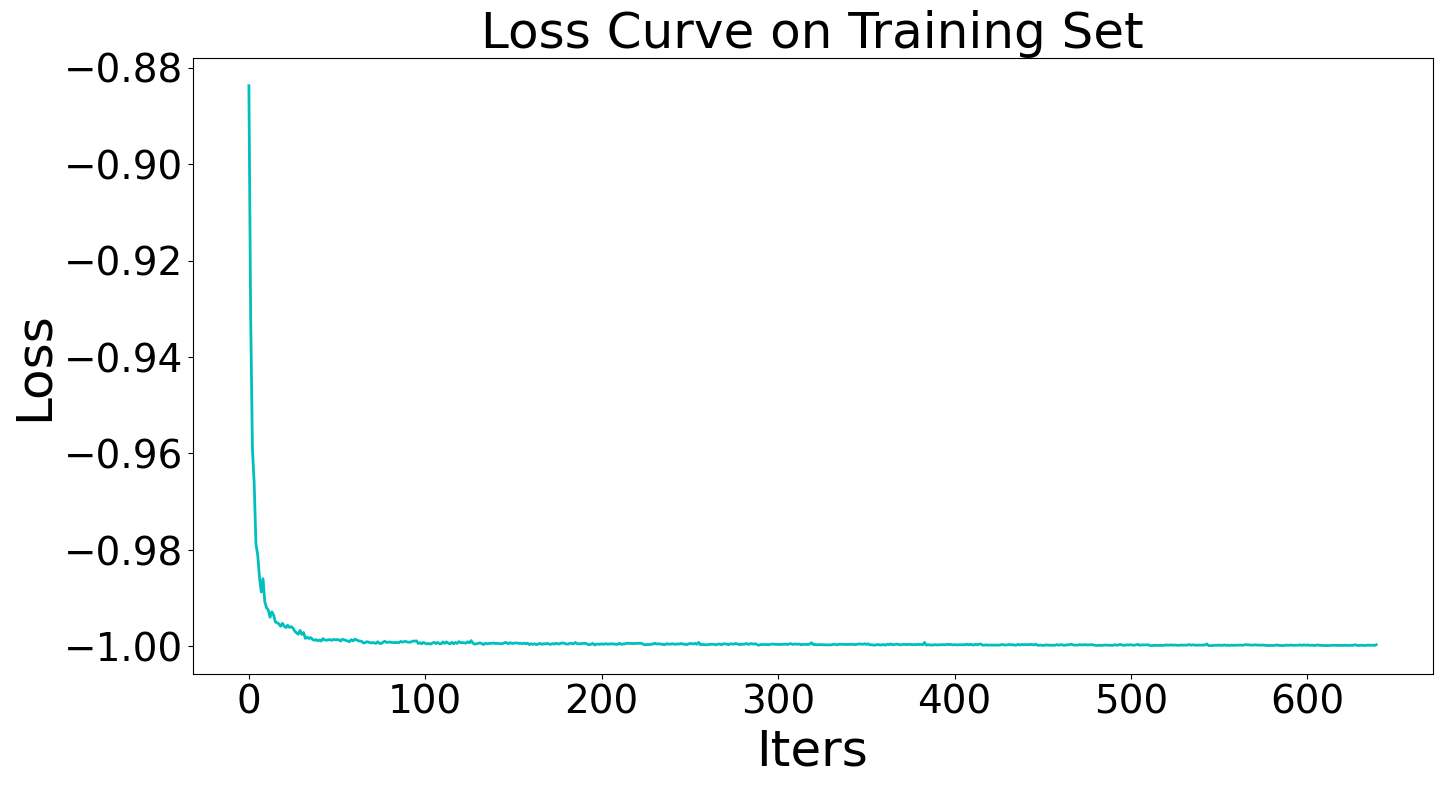

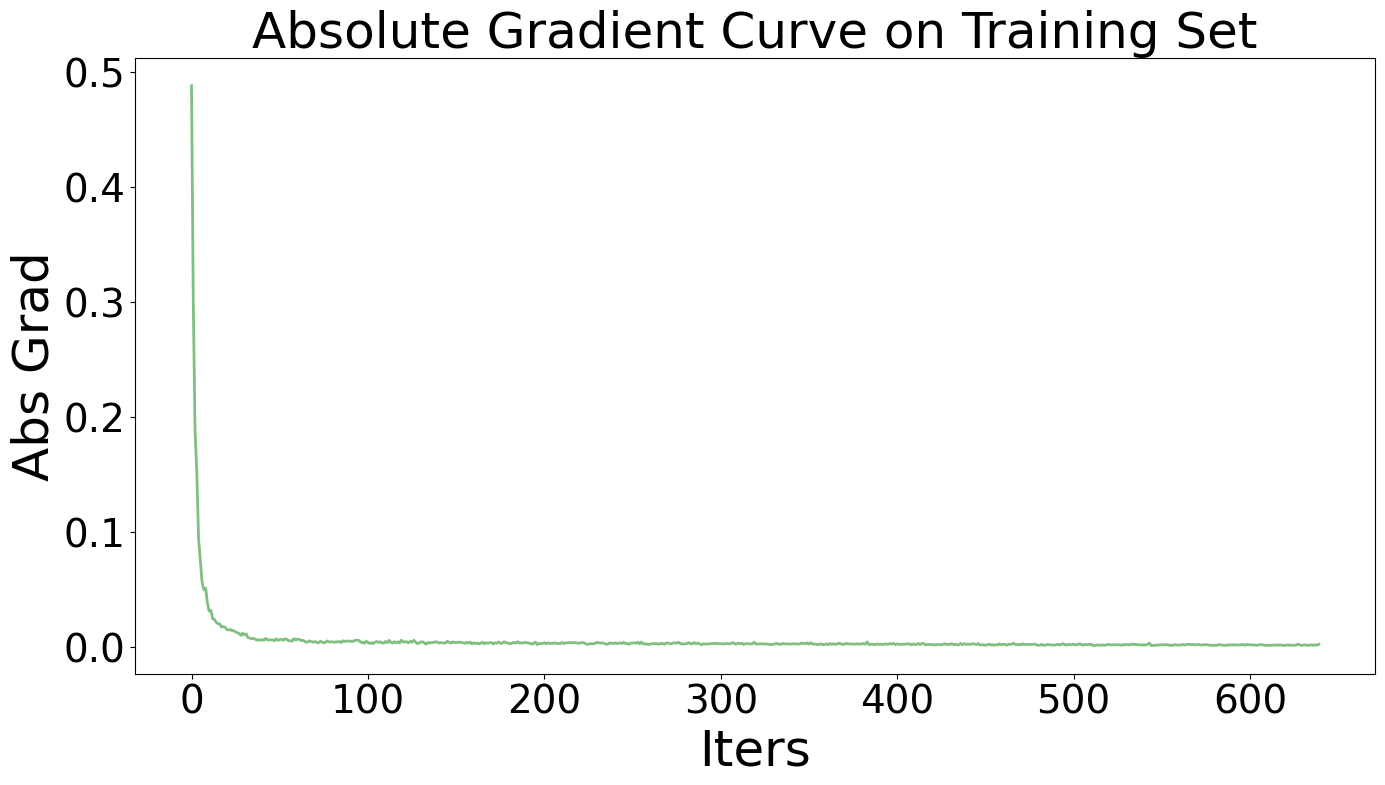

In [16]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Distance 

In [17]:
class exactConeAlignedDist(exactConeAlignedCosine):
    def _calLoss(self, pred_cost, tight_ctrs, optmodel):
        """
        A method to calculate loss.
        """
        # cost vectors direction
        if optmodel.modelSense == EPO.MINIMIZE:
            # minimize
            pred_cost = - pred_cost
        # get projection
        proj = self._getProjection(pred_cost, tight_ctrs) * 100
        # calculate mse
        loss = F.mse_loss(pred_cost, proj)
        return loss

In [18]:
# init model
reg = LinearRegression()

In [19]:
# init loss
ca_dist = exactConeAlignedDist(optmodel, processes=1)

Num of cores: 1


In [20]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_dist, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:10<?, ?it/s]

Epoch   0, Train Regret: 201.8660%, Val Regret: 209.2473%


Epoch    1, Loss:   2.0133:  10%|█████▌                                                 | 2/20 [00:40<04:16, 14.25s/it]

Epoch   2, Train Regret:  49.8721%, Val Regret:  48.0450%


Epoch    3, Loss:   1.1728:  20%|███████████                                            | 4/20 [01:09<03:43, 13.95s/it]

Epoch   4, Train Regret:  18.9141%, Val Regret:  20.4213%


Epoch    5, Loss:   0.3189:  30%|████████████████▌                                      | 6/20 [01:41<03:17, 14.12s/it]

Epoch   6, Train Regret:  16.6682%, Val Regret:  16.2564%


Epoch    7, Loss:   0.5152:  40%|██████████████████████                                 | 8/20 [02:11<02:51, 14.29s/it]

Epoch   8, Train Regret:  15.2553%, Val Regret:  16.3586%


Epoch    9, Loss:   0.3977:  50%|███████████████████████████                           | 10/20 [02:40<02:20, 14.06s/it]

Epoch  10, Train Regret:  13.6857%, Val Regret:  14.7210%


Epoch   11, Loss:   0.1948:  60%|████████████████████████████████▍                     | 12/20 [03:10<01:53, 14.19s/it]

Epoch  12, Train Regret:  12.6216%, Val Regret:  11.4107%


Epoch   13, Loss:   0.0880:  70%|█████████████████████████████████████▊                | 14/20 [03:42<01:25, 14.24s/it]

Epoch  14, Train Regret:  11.5940%, Val Regret:  11.0451%


Epoch   15, Loss:   0.0949:  80%|███████████████████████████████████████████▏          | 16/20 [04:12<00:57, 14.50s/it]

Epoch  16, Train Regret:  10.8230%, Val Regret:  10.6779%


Epoch   17, Loss:   0.0407:  90%|████████████████████████████████████████████████▌     | 18/20 [04:42<00:28, 14.17s/it]

Epoch  18, Train Regret:  10.2547%, Val Regret:  10.5083%


Epoch   19, Loss:   0.0432: 100%|██████████████████████████████████████████████████████| 20/20 [05:01<00:00, 15.09s/it]


Epoch  19, Train Regret:   9.8840%, Val Regret:   9.3790%

Evaluation:
Test Regret: 10.1711%
Training Elapsed Time: 178.10 Sec


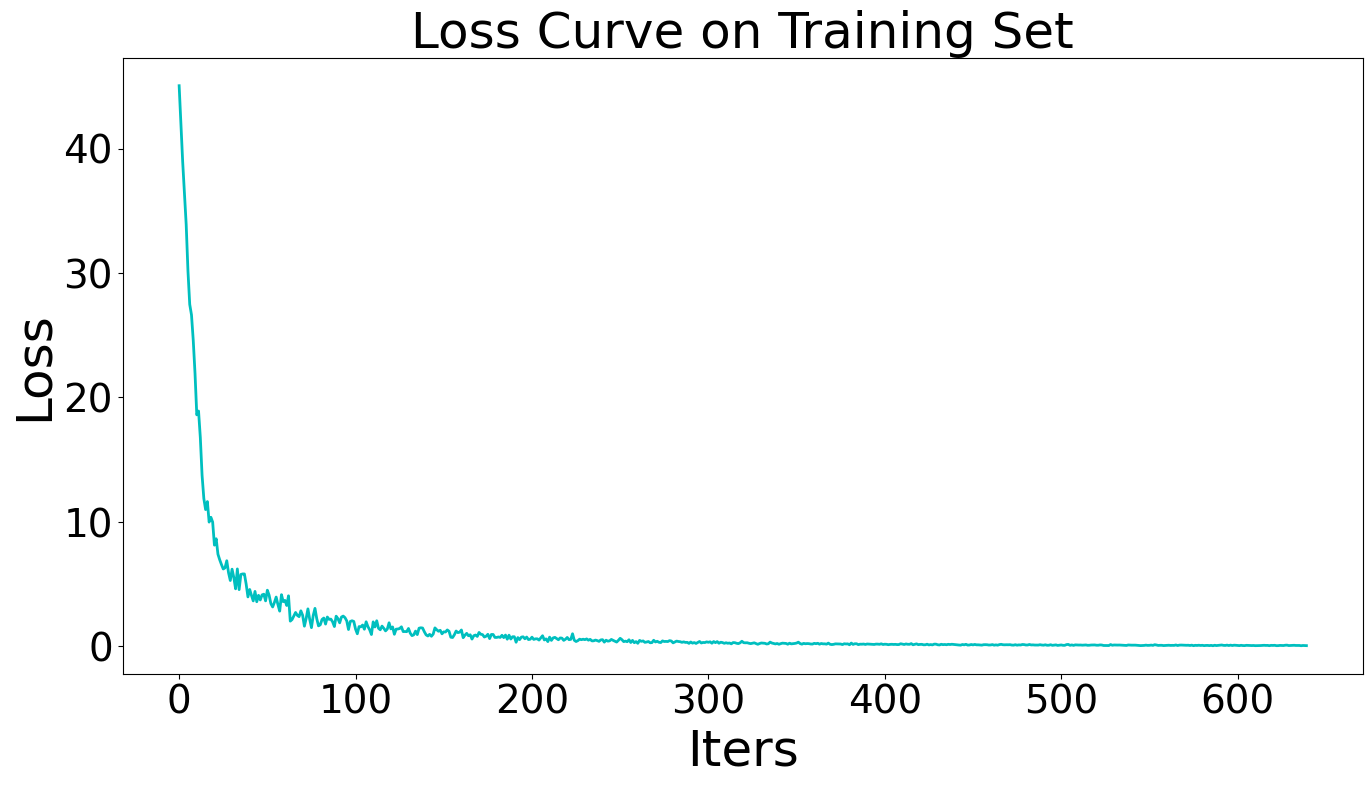

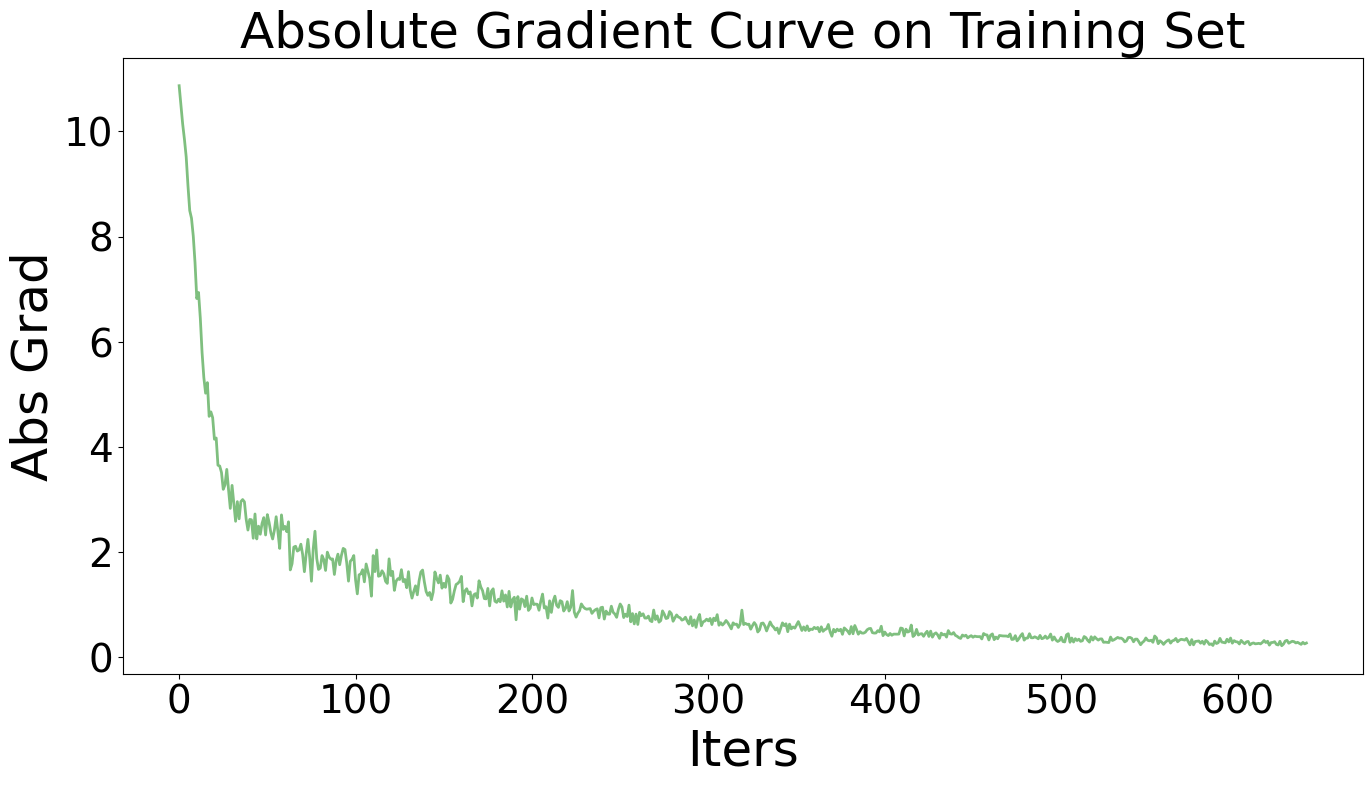

In [21]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [24]:
# init loss
ca_mix = exactConeAlignedMixed(optmodel, processes=1)

Num of cores: 1


In [25]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_mix, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:11<?, ?it/s]

Epoch   0, Train Regret: 201.8660%, Val Regret: 209.2473%


  0%|                                                                                           | 0/20 [00:13<?, ?it/s]


RuntimeError: The size of tensor a (32) must match the size of tensor b (190) at non-singleton dimension 1

In [ ]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)